In [1]:
use_cuda_numpy = False
if use_cuda_numpy:
    import numpy as np
    import matplotlib.pyplot as plt
    import cupy as cnp
    from time import time
    import os
    
else:
    import numpy as cnp
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import os

# $M$, $ND$ Newtonain Interacting Universe Simulator

### Routines

In [2]:
def get_gradient_vector_field_3D(potential_field, real_dtype, dx, dy, dz):
    # Assumes potential_field is [Nx, Ny, Nz]
    gradient = cnp.zeros(potential_field.shape+(3,), dtype=real_dtype)
    # X
    # boundaries with simple Euler formula O(dx)
    gradient[ 0, :, :, 0] = (potential_field[1, :, :]-potential_field[0, :, :])/dx
    gradient[ -1, :, :, 0] = (potential_field[-1, :, :]-potential_field[-2, :, :])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[ 1,:,:, 0] = (potential_field[2,:,:]-potential_field[0,:,:])/(2*dx)
    gradient[ -2,:,:, 0] = (potential_field[-1,:,:]-potential_field[-3,:,:])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[ 2:-2,:,:, 0] = (-potential_field[4:,:,:]+8*potential_field[3:-1,:,:]-8*potential_field[1:-3,:,:]+potential_field[:-4,:,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    gradient[ :, 0, :, 1] = (potential_field[:,1, :]-potential_field[:,0, :])/dx
    gradient[ :,-1, :, 1] = (potential_field[:,-1, :]-potential_field[:,-2, :])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[ :,1,:, 1] = (potential_field[:,2,:]-potential_field[:,0,:])/(2*dx)
    gradient[ :,-2,:, 1] = (potential_field[:,-1,:]-potential_field[:,-3,:])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[ :,2:-2,:, 1] = (-potential_field[:,4:,:]+8*potential_field[:,3:-1,:]-8*potential_field[:,1:-3,:]+potential_field[:,:-4,:])/(12*dx)

    # DZ
    # boundaries with simple Euler formula O(dx)
    gradient[ :,:,0, 2] = (potential_field[:,:,1]-potential_field[:,:,0])/dx
    gradient[ :,:,-1, 2] = (potential_field[:,:,-1]-potential_field[:,:,-2])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[ :,:,1, 2] = (potential_field[:,:,2]-potential_field[:,:,0])/(2*dx)
    gradient[ :,:,-2, 2] = (potential_field[:,:,-1]-potential_field[:,:,-3])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[ :,:,2:-2, 2] = (-potential_field[:,:,4:]+8*potential_field[:,:,3:-1]-8*potential_field[:,:,1:-3]+potential_field[:,:,:-4])/(12*dx)
    return gradient



def get_gradient_vector_field_2D(potential_field, real_dtype, dx, dy):
    # Assumes potential_field is [Nx, Ny]
    gradient = cnp.zeros(potential_field.shape+(2,), dtype=real_dtype)
    # X
    # boundaries with simple Euler formula O(dx)
    gradient[0, :, 0] = (potential_field[1, :]-potential_field[0, :])/dx
    gradient[-1, :, 0] = (potential_field[-1, :]-potential_field[-2, :])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[1,:, 0] = (potential_field[2,:]-potential_field[0,:])/(2*dx)
    gradient[-2,:, 0] = (potential_field[-1,:]-potential_field[-3,:])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[2:-2,:, 0] = (-potential_field[4:,:]+8*potential_field[3:-1,:]-8*potential_field[1:-3,:]+potential_field[:-4,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    gradient[:, 0, 1] = (potential_field[:,1]-potential_field[:,0])/dy
    gradient[:,-1, 1] = (potential_field[:,-1]-potential_field[:,-2])/dy
    # next boundaries with centered difference O(dx**2)
    gradient[:,1, 1] = (potential_field[:,2]-potential_field[:,0])/(2*dy)
    gradient[:,-2, 1] = (potential_field[:,-1]-potential_field[:,-3])/(2*dy)
    # rest with O(dx**4) centered difference
    gradient[:,2:-2, 1] = (-potential_field[:,4:]+8*potential_field[:,3:-1]-8*potential_field[:,1:-3]+potential_field[:,:-4])/(12*dy)
    return gradient

def get_gradient_vector_field_1D(potential_field, real_dtype, dx):
    # Assumes potential_field is [Nx]
    gradient = cnp.zeros(potential_field.shape+(1,), dtype=real_dtype)
    # X
    # boundaries with simple Euler formula O(dx)
    gradient[0,0] = (potential_field[1]-potential_field[0])/dx
    gradient[-1,0] = (potential_field[-1]-potential_field[-2])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[1,0] = (potential_field[2]-potential_field[0])/(2*dx)
    gradient[-2,0] = (potential_field[-1]-potential_field[-3])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[2:-2,0] = (-potential_field[4:]+8*potential_field[3:-1]-8*potential_field[1:-3]+potential_field[:-4])/(12*dx)
    return gradient


def interpolate_traj_force_from_force_field_3D(trajs, force_field):
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs[:,:3]-xlowers)//dxs).T).astype(cnp.uint) # [3, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,cnp.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,cnp.newaxis]
    ratz_down = ((trajs[:,2]-zs[ trajs_idxs[2] ])/(zs[ trajs_idxs[2]+1 ]-zs[ trajs_idxs[2] ]))[:,cnp.newaxis]
    # Get the interpolated force
    return ratx_down*raty_down*ratz_down* force_field[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2]+1 ] +\
        (1-ratx_down)*raty_down*ratz_down* force_field[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2]+1 ] +\
        ratx_down*(1-raty_down)*ratz_down* force_field[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2]+1 ] +\
        ratx_down*raty_down*(1-ratz_down)* force_field[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2] ] +\
        (1-ratx_down)*(1-raty_down)*ratz_down* force_field[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2]+1 ] +\
        ratx_down*(1-raty_down)*(1-ratz_down)* force_field[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2] ] +\
        (1-ratx_down)*raty_down*(1-ratz_down)* force_field[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2] ] +\
        (1-ratx_down)*(1-raty_down)*(1-ratz_down)* force_field[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2] ]
    
def interpolate_traj_force_from_force_field_2D(trajs, force_field):
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs[:,:2]-xlowers)//dxs).T).astype(cnp.uint) # [2, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,cnp.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,cnp.newaxis]
    # Interpolate momentum
    return ratx_down*raty_down* force_field[ trajs_idxs[0]+1, trajs_idxs[1]+1 ] +\
        (1-ratx_down)*raty_down* force_field[ trajs_idxs[0], trajs_idxs[1]+1] +\
        ratx_down*(1-raty_down)* force_field[ trajs_idxs[0]+1, trajs_idxs[1] ] +\
        (1-ratx_down)*(1-raty_down)* force_field[ trajs_idxs[0], trajs_idxs[1]] #[numTrajs,2]


def estimate_pdf_from_trajs(trajs, grid, sigma, real_dtype):
    pdf = cnp.zeros(grid.shape[1:], dtype=real_dtype)
    # vectorizing is is too memory costly, it would require
    # one whole grid per trajectory! so better use a for loop
    N = 1/(sigma*np.sqrt(2*np.pi)*trajs.shape[0])
    for traj in trajs:
        pdf+=N*cnp.exp(
            -(grid-traj)**2/(2*sigma)**2) # for arbitrary 
    return pdf

- Hacer que grid solo se use cuando es 2D o es 3D y punto. Y que por tanto el 3D y 2D tengan su plot particular.
- Si es Universos de más dimensiones, hacer el cálculo de la pdf estimada sobre cada trayectorai con los kernels y colorear cada Universo con ese color relativo.

### Simulation Parameters

Using dt=0.001; dt_TISE=0.01 -> dt = 0.1*dt_TISE


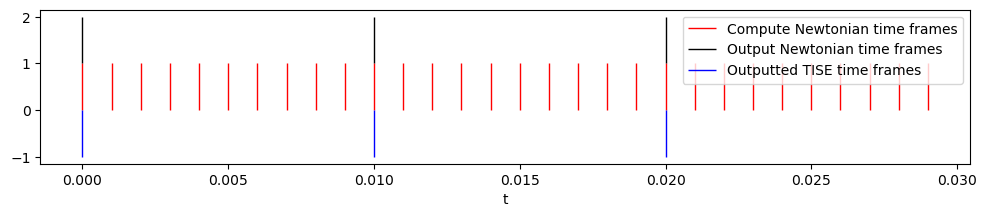

In [3]:
# If want to use reference TISE simulation for comparison, write
# the same experiment name and the paths to the outputs
exp_name = "2D_test"

# Number precision
complex_dtype = cnp.csingle # 64 bit #cnp.cdouble # 128 bit
real_dtype = cnp.single # 32 bit # cnp.double # 64 bit

# Time increment
dt = 0.001

# The standard deviation of the kernel gaussians
sigma = 1

TISE_path = f"./OUTPUTS/TISE_2D/{exp_name}/"
# IF USING TISE DATA AS REFERENCE! ###########################################
if TISE_path:
    with open(f"{TISE_path}/Settings.txt", "r") as f:
        numIts_TISE = int(f.readline().split("numIts ")[1])
        dt_TISE = float(f.readline().split("dt ")[1])
        outputEvery_TISE = int(f.readline().split("outputEvery ")[1])
        Ns = [float(x) for x in f.readline().split("Ns ")[1].split('[')[1].split(']')[0].split(',')]
        xlowers = [float(x) for x in f.readline().split("xlowers ")[1].split('[')[1].split(']')[0].split(',')]
        xuppers = [float(x) for x in f.readline().split("xuppers ")[1].split('[')[1].split(']')[0].split(',')]
        numDofUniv = int(f.readline().split("numDofUniv ")[1])
        numDofPartic = int(f.readline().split("numDofPartic ")[1])
        numTrajs = int(f.readline().split("numTrajs ")[1])
        hbar = float(f.readline().split("hbar ")[1])
        ms = [float(x) for x in f.readline().split("ms ")[1].split('[')[1].split(']')[0].split(',')]
        f.readline() # dtype complex
        f.readline() # dtype real
        try:
            K_coulomb = float(f.readline().split("K_coulomb ")[1])
            qs = [float(x) for x in f.readline().split("qs ")[1].split('[')[1].split(']')[0].split(',')]
        except:
            K_coulomb = 1
            qs=[1]*numDofPartic
        # Tricks to match the output frames - DO NOT EDIT THIS!
        # Adapt the chosen dt to the closest one such that it is possible to match frames
        # That is, make them commensurate
        if dt_TISE>dt:
            dt=int(dt_TISE//dt)**-1*dt_TISE
        else: # we need at least the same rate of outputs to compare one to one
            dt=dt_TISE

        print(f"Using dt={dt:.3}; dt_TISE={dt_TISE:.3} -> dt = {dt/dt_TISE:.3}*dt_TISE")

        # Match the output number
        outputEvery = int(dt_TISE//dt)

        # Total number of iterations
        numIts = int(numIts_TISE*(dt_TISE//dt))


        # Time grid
        ts = np.array([dt*j for j in range(numIts)])
        ts_TISE = np.array([dt_TISE*j for j in range(numIts_TISE)])

        fig=plt.figure(figsize=(12, 2))
        ax=fig.add_subplot(111)
        ax.vlines(ts[:3*int(dt_TISE//dt)], 0, 1,  label="Compute Newtonian time frames", color="red", linewidth=1)
        ax.vlines(ts[:3*int(dt_TISE//dt):outputEvery], 1, 2,  label="Output Newtonian time frames", color="black", linewidth=1)
        ax.vlines(ts_TISE[:3], -1, 0,  label="Outputted TISE time frames", color="blue", linewidth=1)
        ax.legend()
        ax.set_xlabel("t")
        plt.show()
else: #####################################################################
    # IF NOT USING TISE DATA AS REFERENCE!
    # Number of Tangent Universes
    numTrajs=80

    # Number of Dimensions per Universe, aka configuration space
    numDofUniv = 3
    numDofPartic = 3

    # Masses per dof
    ms = cnp.array([1]*numDofUniv)[cnp.newaxis, :]

    # Constants
    K_coulomb=1
    hbar = 1
    qs=cnp.array([1]*(numDofUniv//numDofPartic))

    # Intervals for calculating the wave function
    xlowers = [-4,-4,-4]
    xuppers = [4,4,4]
    
    # Spatial nodes for the pdf estimation and potential fields
    Ns = [10,10,10] # (Nx, Ny, Nz)

For the potential and force fields

In [4]:
# Increments to be used per dimension
dxs = [(xuppers[j]-xlowers[j])/(Ns[j]-1) for j in range(numDofUniv)] # (dx, dy, dz)
dxs = cnp.array(dxs)[cnp.newaxis,:]

#Create coordinates at which the solution will be calculated
nodes = [cnp.linspace(xlowers[j], xuppers[j], Ns[j]) for j in range(3)] # (xs, ys, zs)
xlowers = cnp.array(xlowers)[cnp.newaxis, :]
xuppers = cnp.array(xuppers)[cnp.newaxis, :]

# Create a node mesh
grid=cnp.array(cnp.meshgrid(*nodes)).swapaxes(1,2) #[3,Nx,Ny,Nz]

IndexError: list index out of range

### Scenario


#### Extra-Universe Forces

In [12]:
def harmonic_external_force(trajs, K=1):
    return -2*K*trajs[:,:numDofUniv] #[numTrajs, dofsUniv]

def double_slit_external_potential_3D(xyz_grid):
    return cnp.ones(xyz_grid.shape[1:]) #[Nx,Ny,Nz]

def double_slit_external_potential_2D(xy_grid):
    return cnp.ones(xy_grid.shape[1:]) #[Nx,Ny]

def double_slit_external_potential_1D(xy_grid):
    return cnp.ones(x_grid.shape[1:]) #[Nx]


if numDofUniv==3:
    potential_field = double_slit_external_potential_3D(grid) #[Nx,Ny,Nz]
    external_force_field = get_gradient_vector_field_3D(
                        potential_field, real_dtype,dx,dy,dz) #[Nx,Ny,Nz, 3]
    external_force = lambda trajs: interpolate_traj_force_from_force_field_3D(
                        trajs, force_field=external_force_field)

elif numDofUniv==2:
    potential_field = double_slit_external_potential_2D(grid) #[Nx,Ny]
    external_force_field = get_gradient_vector_field_2D(
                        potential_field, real_dtype,dx,dy) #[ Nx,Ny, 2]
    external_force = lambda trajs: interpolate_traj_force_from_force_field_2D(
                        trajs, force_field=external_force_field)

else:
    potential_field = double_slit_external_potential_1D(grid) #[Nx]
    external_force_field = get_gradient_vector_field_1D(
                        potential_field, real_dtype,dx) #[ Nx]  
    external_force = lambda trajs: interpolate_traj_force_from_force_field_1D(
                        trajs, force_field=external_force_field)

scenario_forces = [
        harmonic_external_force
    ] # external forces

#### Inter-Particle Intra-Universe Forces

- Calcular de forma vectorizada la distancia entre todo par de puntos de trajectories!
- Hacer Coulomb asumiendo dofuniv arbitraria y hacer inter-universe adibidetxu bat
- Ein que las trajs reboten en los bordes
- Plotietako rutinie, alzu ein rekonstrukziño bat de la wavefunction pdf gubazun
- Probeu dana hasta que quede bien
- Ein funtziñoak metrikak atateko en comparativa
- Ein pipeline para que automáticamente probeu las diferentes inter-Universe potentials!

In [13]:
def coulomb_force(trajs, qs, numDofPartic, K):
    numPartics = trajs.shape[1]//numDofPartic
    trajsPerParticl = trajs.reshape(trajs.shape[0],
                  numPartics,
                  numDofPartic) #[numTrajs, numPartcls, dimPerParticl]
    relativeVecsPerParticle=(trajsPerParticl[:,:,:,cnp.newaxis]-trajsPerParticl[:,cnp.newaxis,:,:].swapaxes(-2,-1)).swapaxes(-2,-1)
    # [numTrajs, numPartcls, numPartcls, dimPerParticl] 
    # (k,i,j) is x^part_i_xik-x^part_j_xik vector [dimPerPartcl]
    relative_distances = cnp.linalg.norm(relative_vecs, axis=-1, keepdims=True) 
    # [numTrajs, numPartcls, numPartcls, 1] 
    # to avoid self-interaction, we make the relative distance with themselves infinite
    relative_distances[:,cnp.arange(numPartics), cnp.arange(numPartics)]=cnp.inf
    # Compute the forces of all particles with all the rest
    all_forces = K*relativeVecsPerParticle/relative_distances**(2+1)
    all_forces = all_forces*qs[cnp.newaxis,:,cnp.newaxis,cnp.newaxis]*qs[cnp.newaxis,cnp.newaxis,:,cnp.newaxis] 
    # [numTrajs, numPartcls, numPartcls, dimPerParticl]
    # +1 to make them unit vectors from i-th to j-th
    # (k,i,j) is the force at Universe k from particle j on i-th
    # we sum all the inter-particle forces on i-th particle of Universe k
    total=all_forces.sum(axis=2) # sum over j-> # [numTrajs, numPartcls, dimPerParticl]
    return total.reshape(total.shape[0],-1) #[numTrajs, dofPerUniverse]

coulomb_force = lambda x1_xi1, x2_xi1 : coulomb_force(trajs,
                                qs=qs, numDofPartic=numDofPartic, K=K_coulomb)

inter_particle_forces_within_universe = [
        #coulomb_force
    ] # classical forces

#### Inter-Universe Forces

In [14]:
def inter_universe_force(trajs, A, K):
    relative_vecs = (trajs[:,:,None]-trajs[:,:,None].T).swapaxes(1,2)
    # relative_vecs is [numTrajs, numTrajs, dofUniv] s.t. (i,j) is the x_xi1-x_xi2 vec
    # that is, the vector from i-th to j-th
    relative_distances = cnp.linalg.norm(relative_vecs, axis=-1, keepdims=True) #[numTrajs, numTrajs, 1]
    # to avoid self-interaction, we make the relative distance with themselves infinite
    relative_distances[cnp.arange(len(trajs)), cnp.arange(len(trajs))]=cnp.inf
    all_forces=A*relative_vecs/relative_distances**(K+1) # [numTrajs, numTrajs, dofUniv]
    # +1 to make them unit vectors from i-th to j-th
    # (i,j) is the force of trajectory j on i-th
    # we sum all the inter-universe forces on i-th
    return all_forces.sum(axis=1) # sum over j

quantum_force = lambda trajs : inter_universe_force(trajs, A=1, K=2)

inter_universe_forces = [
        quantum_force
    ] # origin of quantum

#### Sample trajectories if not using reference simulation!

In [ ]:
if not TISE_path:
    # Initial Wavefunction
    def psi0_gaussian(x,mu, sigma, p, hbar):
        return 1/(sigma*cnp.sqrt(2*cnp.pi))**0.5*cnp.exp(-(x-mu)**2/(4*sigma**2))*\ 
                    cnp.exp(1j*(p*x)/hbar)

    # parameters for gaussian
    mus = [0]*numDofUniv
    sigmas = [1]*numDofUniv
    ps = [0]*numDofUniv
    psi0 = lambda x,y,z: psi0_gaussian(x,y,z, mus=mus, sigmas=sigmas, ps=ps, hbar=hbar)
    # buuf

### Simulation

Prepare Arrays

In [16]:
trajs = cnp.load(trajs_TISE_path+f"/trajs_it_0_numIts_{numIts_TISE}_dt_{dt_TISE:.3}.npy")
# [numTrajs, 2*dof_Universe]

# For the Verlet algorithm, saving at least 3 time iterations is necessary
positions = cnp.zeros(( 3, trajs.shape[0], trajs.shape[1]), dtype=real_dtype)
#[3 (current, -1,-2), numTrajs, dof_Univ]

# for the first time iteration we will estimate the previous position of the
# particle using a simple Euler rule given the initial velocities
positions[:] = trajs[:, :numDofUniv]-dt*trajs[:, numDofUniv:]/ms
positions[0,:,:] = trajs[:, :numDofUniv] # newest time in position 0, then 1, then 2

# shorthand
dt2_masses = dt**2/(ms[0,:,cnp.newaxis])

# a Nx3 array (matrix) where we will save the forces in each time
forces = cnp.zeros(positions_now.shape, dtype=real_dtype)

ValueError: operands could not be broadcast together with shapes (80,0) (1,3) 

Create Directories

In [ ]:
os.makedirs(f"./OUTPUTS/MIW/{exp_name}/pdf/", exist_ok=True)
os.makedirs(f"./OUTPUTS/MIW/{exp_name}/trajs/", exist_ok=True)

Run Iterations

Ein force functionak, de forma que tan sólo pidan de comer todos los chis y dofs para el IU y el external, y o todos o por cada chi en las IP

In [ ]:
for it, t in enumerate(ts):
    # Step 1, compute the total force on each dof
    for force in scenario_forces:
        forces = force(trajs)
    for force in inter_particle_forces_within_universe:
        forces += force(trajs)
    for force in inter_universe_forces:
        forces += force(trajs)
        
    # OUTPUT of current state
    if it%plotEvery==0:
        print(f"\n > It {it}/{numIts}")
        #trajs_numpy = cnp.asnumpy(trajs)
        trajs_numpy = trajs
        np.save(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                trajs_numpy, allow_pickle=True) #[numTrajs, numDofUniv]
        # Estimate pdf
        pdf = estimate_pdf_from_trajs(trajs, grid, sigma=sigma, real_dtype=real_dtype)
        #pdf = cnp.asnumpy(pdf)
        np.save(f"./OUTPUTS/MIW/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                pdf, allow_pickle=True) #[Nx,Ny,Nz]
    
    # Step 2, compute the position of the particles in the next time
    # first move all the positions one slot onward in time
    positions[1:, :, :] = positions[:-1,:,:] 
    # copy in the slots from 1 to 3 the ones that were in 0 to 2

    positions[0,:,:] = 2*positions[1,:,:] - positions[2,:,:] + forces*dt2_masses
    # Copy results in trajectory array
    traj[:, :numDofUniv] = positions[0,:,:]

    # Step 3, compute the momentum in the next time for plotting purposes
    traj[:, numDofUniv:] = traj[:,numDofUniv:]+forces*dt
    
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]>xuppers,
                        xuppers-(trajs[:,:numDofUniv]-xuppers) ,trajs[:,:numDofUniv] )
    trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]<xlowers,
                        xlowers+(xlowers-trajs[:,:numDofUniv]) ,trajs[:,:numDofUniv] )   

### Animation Generation

In [170]:
os.makedirs(f"./OUTPUTS/MIW/{exp_name}/figs/", exist_ok=True)
image_paths = []
dpi=100

# The best thing would be to have a different color per
# point in configuration space, such that trajectories that
# come close to each other are colored similarly, 
# but this is not possible for more than 3D of configuration space!
# because colors are generated by 3 dof!
# so just fixed random colors shall be okay
cmap = mpl.colormaps['hsv'].resampled(numTrajs) # one color per Universe
color_per_Universe = cmap(np.arange(numTrajs))

# Each particle will have its own marker type in the physical space
marker_per_particle = ['o', 's', 'p', '^', 'd', '*']

Generate png

If the physical space within each Universe is 3D

In [ ]:
if numDofPartic==3:
    every=1 # Only take one data point every this number in each axis to plot
    grid=np.array(np.meshgrid(*nodes)).swapaxes(1,2)[:,::every, ::every, ::every] #[3,Nx,Ny,Nz]
    print(f"Using a mesh in the plot of {grid.shape}")
    fig = plt.figure( figsize=(14,7))
    #plt.style.use('dark_background')

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")
            fig.clf()
            pdf = np.load(f"./OUTPUTS/MIW/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")

            ax = fig.add_subplot(121, projection='3d')
            # PDF TRANSP ############################################################
            maxim = pdf.max()
            minim = pdf.min()
            level_surface = grid[:, pdf>maxim/3]
            colormap = ax.scatter(*level_surface, c=pdf[pdf>maxim/3],
                    cmap='hot_r', s=2, alpha=pdf[pdf>maxim/3]/maxim ) #, antialiased=True)
            ax.set_xlim((xlowers[0,0], xuppers[0,1]))
            ax.set_ylim((xlowers[0,1], xuppers[0,1]))
            ax.set_zlim((xlowers[0,2], xuppers[0,2]))

            fig.colorbar(colormap, fraction=0.04, location='left')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_title(f"Probability Density>{maxim/3:.3}\n it={it} t={t:.4}")

            # PDF + TRAJECTORIES ##############################################
            ax = fig.add_subplot(122, projection='3d')
            #colormap = ax.scatter3D(*grid, c=pdf[ ::every, ::every, ::every],
            #               cmap='hot_r', s=0.1, alpha=0.4 ) #, antialiased=True)
            cset = ax.contour(grid[0,:,:,0], grid[1,:,:,0], pdf.sum(axis=2), 7, zdir='z', offset=xlowers[0,2], cmap='hot_r')
            cset = ax.contour(grid[0,:,0,:], pdf.sum(axis=1), grid[2,:,0,:], 7, zdir='y', offset=xuppers[0,1], cmap='hot_r')
            cset = ax.contour(pdf.sum(axis=0), grid[1,0,:,:], grid[2,0,:,:], 7, zdir='x', offset=xlowers[0,0], cmap='hot_r')
            #fig.colorbar(cset, fraction=0.04, location='left')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_title(f"Trajectories and Projected Estimated pdf Contours\nColor==Universe; Shape==Particle\nit={it} t={t:.4}")

            # The color will indicate Universe and marker will indicate particle
            for particle in range(numDofUniv//numDofPartic):
                ax.scatter(trajs[:,particle*numDofPartic], 
                        trajs[:,particle*numDofPartic+1],
                        trajs[:,particle*numDofPartic+2], 
                       c=color_per_Universe, marker=marker_per_particle[particle],
                       s=3, alpha=1)

            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)
            plt.show()
            break


Generate png

If the physical space within each Universe is 2D

In [ ]:
if numDofPartic==2:
    every=1 # Only take one data point every this number in each axis to plot
    grid=np.array(np.meshgrid(*nodes)).swapaxes(-2,-1)[:,::every, ::every] #[2,Nx::ev,Ny]
    print(f"Using a mesh in the plot of {grid.shape}")
    fig = plt.figure( figsize=(14,7))

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")
            fig.clf()
            pdf = np.load(f"./OUTPUTS/MIW/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")

            ax = fig.add_subplot(121, projection='3d')
            maxim = pdf.max()
            minim = pdf.min()
            # PDF ############################################################
            colormap = ax.plot_surface(grid[0], grid[1], pdf, rcount=50, ccount=50,
                    cmap='RdYlBu')
            fig.colorbar(colormap, fraction=0.04, location='left')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("Probability Density")
            ax.set_title(f"Probability Density it={it} t={t:.4}")
            cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='x', 
                              offset=xlowers[0,0], cmap='RdYlBu', vmax=maxim, vmin=minim)
            cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='y',
                              offset=xuppers[0,1], cmap='RdYlBu', vmax=maxim, vmin=minim)

            # PDF + TRAJECTORIES ##############################################
            ax = fig.add_subplot(122)
            colormap = ax.imshow(pdf.T, 
                 extent=[xlowers[0,0], xuppers[0,0], xlowers[0,1], xuppers[0,1]]
                                 , origin='lower',cmap='RdYlBu')
            #plt.axis(aspect='image');
            fig.colorbar(colormap, fraction=0.04, location='right')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title(f"Trajectories and Probability Density\n it={it} t={t:.4}")
            # The color will indicate Universe and marker will indicate particle
            for particle in range(numDofUniv//numDofPartic):
                ax.scatter(trajs[:,particle*numDofPartic], 
                        trajs[:,particle*numDofPartic+1],
                       c=color_per_Universe, marker=marker_per_particle[particle],
                       s=3, alpha=1)
            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)

Generate png

If the physical space within each Universe is 1D

Generate gif

Erase png

In [98]:
trajs = np.arange(30).reshape(5,6)
numDofPartic = 2
trajsPerParticl = trajs.reshape(trajs.shape[0],
                  trajs.shape[1]//numDofPartic,
                  numDofPartic) #[numTrajs, numPartcls, dimPerParticl]
relativeVecsPerParticle=(trajsPerParticl[:,:,:,np.newaxis]-trajsPerParticl[:,np.newaxis,:,:].swapaxes(-2,-1)).swapaxes(-2,-1)
# [numTrajs, numPartcls, numParticls, dimPerParticl] 
# (k,i,j) is x^part_i_xik-x^part_j_xik vector [dimPerPartcl]

In [96]:
print(trajs)
relative_vecs = (trajs[:,:,None]-trajs[:,:,None].T).swapaxes(1,2)
# (i,j) is the x_xi1-x_xi2 [dofUniv] vec
relative_distances = np.linalg.norm(relative_vecs, axis=-1)

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]]


In [97]:
relative_distances[np.arange(len(trajs)), np.arange(len(trajs))]=np.inf
relative_distances

array([[        inf, 14.69693846, 29.39387691, 44.09081537, 58.78775383],
       [14.69693846,         inf, 14.69693846, 29.39387691, 44.09081537],
       [29.39387691, 14.69693846,         inf, 14.69693846, 29.39387691],
       [44.09081537, 29.39387691, 14.69693846,         inf, 14.69693846],
       [58.78775383, 44.09081537, 29.39387691, 14.69693846,         inf]])

In [91]:
relative_distances = np.linalg.norm(relativeVecsPerParticle, axis=-1, keepdims=True) 
relative_distances[:,np.arange(3), np.arange(3)]=np.inf
relative_distances

array([[[[       inf],
         [2.82842712],
         [5.65685425]],

        [[2.82842712],
         [       inf],
         [2.82842712]],

        [[5.65685425],
         [2.82842712],
         [       inf]]],


       [[[       inf],
         [2.82842712],
         [5.65685425]],

        [[2.82842712],
         [       inf],
         [2.82842712]],

        [[5.65685425],
         [2.82842712],
         [       inf]]],


       [[[       inf],
         [2.82842712],
         [5.65685425]],

        [[2.82842712],
         [       inf],
         [2.82842712]],

        [[5.65685425],
         [2.82842712],
         [       inf]]],


       [[[       inf],
         [2.82842712],
         [5.65685425]],

        [[2.82842712],
         [       inf],
         [2.82842712]],

        [[5.65685425],
         [2.82842712],
         [       inf]]],


       [[[       inf],
         [2.82842712],
         [5.65685425]],

        [[2.82842712],
         [       inf],
         [2.82842712]],